In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [3]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [6]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'spec_star.p')

In [7]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [8]:
stim_cats = spec_df.stim.unique().tolist()

In [9]:
spec_list = spec_df.spec.values.tolist()

In [10]:
h, w = spec_list[0].shape

In [11]:
print(h, w)

186 76


## make model and load weights

In [12]:
clear_session()

In [13]:
model=self_VGG()

In [14]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

In [16]:
def distance_ratio(d1, d2):
    """
    compare the distance between v0-v1 and v0-v2, then put the recognition confidence between v1 and v2"""
    ratio=[]
    try: 
        for d01, d02 in zip(d1, d2):
            ratio.append(d01/(d01+d02))
    except:
        ratio = d1/(d1+d2)
    return ratio

In [17]:
def distance_to_confidence(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then put the recognition confidence between v1 and v2"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    if d01<0.001:
        return 0
    elif d02<0.001:
        return 1
    else:
#         return np.exp(1/d02)/(np.exp(1/d01)+np.exp(1/d02))
        return (1/d02)/(1/d01+1/d02)

In [18]:
def min_distance(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then return the smaller one"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    return min(d01, d02)

In [19]:
def avrg_distance(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then return the average"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    return np.mean([d01, d02])

In [20]:
def flip_at_peak(list1, list2, monotonous=False):
    """
    compare the values in list 1 (monotonously increasing) and list 2 (monotonously decreasing),
    start with list 1 values, once they cross, flip list 2 values based on cross value"""
    
    if monotonous:
        cross_index = np.argmin(np.abs(np.array(list1)-np.array(list2)))
    else:
        diff = np.array(list1)-np.array(list2)
        l1high_indeces = [i for i in range(len(list1)-2) if (diff[i]>0) and (diff[i+1]>0) and (diff[i+2]>0)]
        cross_index = l1high_indeces[0]
    peak_val = list1[cross_index]
    comb_list = list1[:cross_index]+list(2*peak_val-np.array(list2[cross_index:]))
    
    return comb_list

In [21]:
def normalize_robust(l):
    new_l = (np.array(l)-np.median(l[:10]))/np.median(l[-10:])
    new_l[new_l>1]=1.
    new_l[new_l<0]=0
    return list(new_l)

# Group 1

In [22]:
group_stim_cats = generate_stim_combos('abcd', 'efgh')

In [23]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group1/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

In [24]:
cat_list = []
id_list = []
feature_rmse_list_init = []
feature_cosine_list_init = []
spec_rmse_list_init = []
feature_rmse_list_final = []
feature_cosine_list_final = []
spec_rmse_list_final = []
less_dim_list = []
more_dim_list = []

feature_rmse_list_comb = []
feature_cosine_list_comb = []
spec_rmse_list_comb = []

feature_rmse_list_norm = []
feature_cosine_list_norm = []
spec_rmse_list_norm = []


for cat in group_stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # cat lists
    feature_rmse_list_init_cat = []
    feature_cosine_list_init_cat = []
    spec_rmse_list_init_cat = []
    
    feature_rmse_list_final_cat = []
    feature_cosine_list_final_cat = []
    spec_rmse_list_final_cat = []
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
        feature_rmse_list_init_cat.append(init_feature_rmse)
        feature_rmse_list_final_cat.append(final_feature_rmse)
        feature_cosine_list_init_cat.append(init_feature_cosine)
        feature_cosine_list_final_cat.append(final_feature_cosine)
        spec_rmse_list_init_cat.append(init_spec_rmse)
        spec_rmse_list_final_cat.append(final_spec_rmse)
        
    feature_rmse_list_init += feature_rmse_list_init_cat
    feature_rmse_list_final += feature_rmse_list_final_cat
    feature_cosine_list_init += feature_cosine_list_init_cat
    feature_cosine_list_final += feature_cosine_list_final_cat
    spec_rmse_list_init += spec_rmse_list_init_cat
    spec_rmse_list_final += spec_rmse_list_final_cat
    
    feature_rmse_list_comb_cat = distance_ratio(feature_rmse_list_init_cat, feature_rmse_list_final_cat)
    feature_cosine_list_comb_cat = distance_ratio(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
    spec_rmse_list_comb_cat = distance_ratio(spec_rmse_list_init_cat, spec_rmse_list_final_cat)
    
    feature_rmse_list_comb += feature_rmse_list_comb_cat
    feature_cosine_list_comb += feature_cosine_list_comb_cat
    spec_rmse_list_comb += spec_rmse_list_comb_cat
    
    feature_rmse_list_norm += normalize_robust(feature_rmse_list_comb_cat)
    feature_cosine_list_norm += normalize_robust(feature_cosine_list_comb_cat)
    spec_rmse_list_norm += normalize_robust(spec_rmse_list_comb_cat)
    
    paragraph_print(f'Done with {cat}', separation='*')

Done with ae
**************************************************
Done with af
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with cf
**************************************************
Done with cg
**************************************************
Done with ch
**************************************************
Done with de
**************************************************
Done with df
**************************************************
Done with dg
**************************************************
Done with dh
***************************

In [25]:
morph_df_1 = pd.DataFrame()
morph_df_1['morph_dim'] = cat_list
morph_df_1['id'] = id_list

morph_df_1['lesser_dim'] = less_dim_list
morph_df_1['greater_dim'] = more_dim_list
morph_df_1['init_feature_rmse'] = feature_rmse_list_init
morph_df_1['final_feature_rmse'] = feature_rmse_list_final
morph_df_1['init_feature_cosine'] = feature_cosine_list_init
morph_df_1['final_feature_cosine'] = feature_cosine_list_final
morph_df_1['init_spec_rmse'] = spec_rmse_list_init
morph_df_1['final_spec_rmse'] = spec_rmse_list_final

morph_df_1['comb_feature_rmse'] = feature_rmse_list_comb
morph_df_1['comb_feature_cosine'] = feature_cosine_list_comb
morph_df_1['comb_spec_rmse'] = spec_rmse_list_comb

morph_df_1['norm_feature_rmse'] = feature_rmse_list_norm
morph_df_1['norm_feature_cosine'] = feature_cosine_list_norm
morph_df_1['norm_spec_rmse'] = spec_rmse_list_norm

In [26]:
morph_df_1.head()

,morph_dim,id,lesser_dim,greater_dim,init_feature_rmse,final_feature_rmse,init_feature_cosine,final_feature_cosine,init_spec_rmse,final_spec_rmse,comb_feature_rmse,comb_feature_cosine,comb_spec_rmse,norm_feature_rmse,norm_feature_cosine,norm_spec_rmse
0,ae,1,a,e,0.000000,0.600543,0.000000,0.686538,0.000000,0.320738,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,ae,2,a,e,0.009308,0.591407,0.000045,0.677773,0.028513,0.320614,0.015495,0.000066,0.081668,0.0,0.0,0.0
2,ae,3,a,e,0.074291,0.529229,0.001344,0.644926,0.038934,0.321018,0.123096,0.002080,0.108164,0.0,0.0,0.0
3,ae,4,a,e,0.086826,0.516576,0.002161,0.632144,0.043152,0.321334,0.143895,0.003406,0.118391,0.0,0.0,0.0
4,ae,5,a,e,0.119033,0.485547,0.004947,0.604698,0.049272,0.323246,0.196886,0.008114,0.132267,0.0,0.0,0.0


/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2


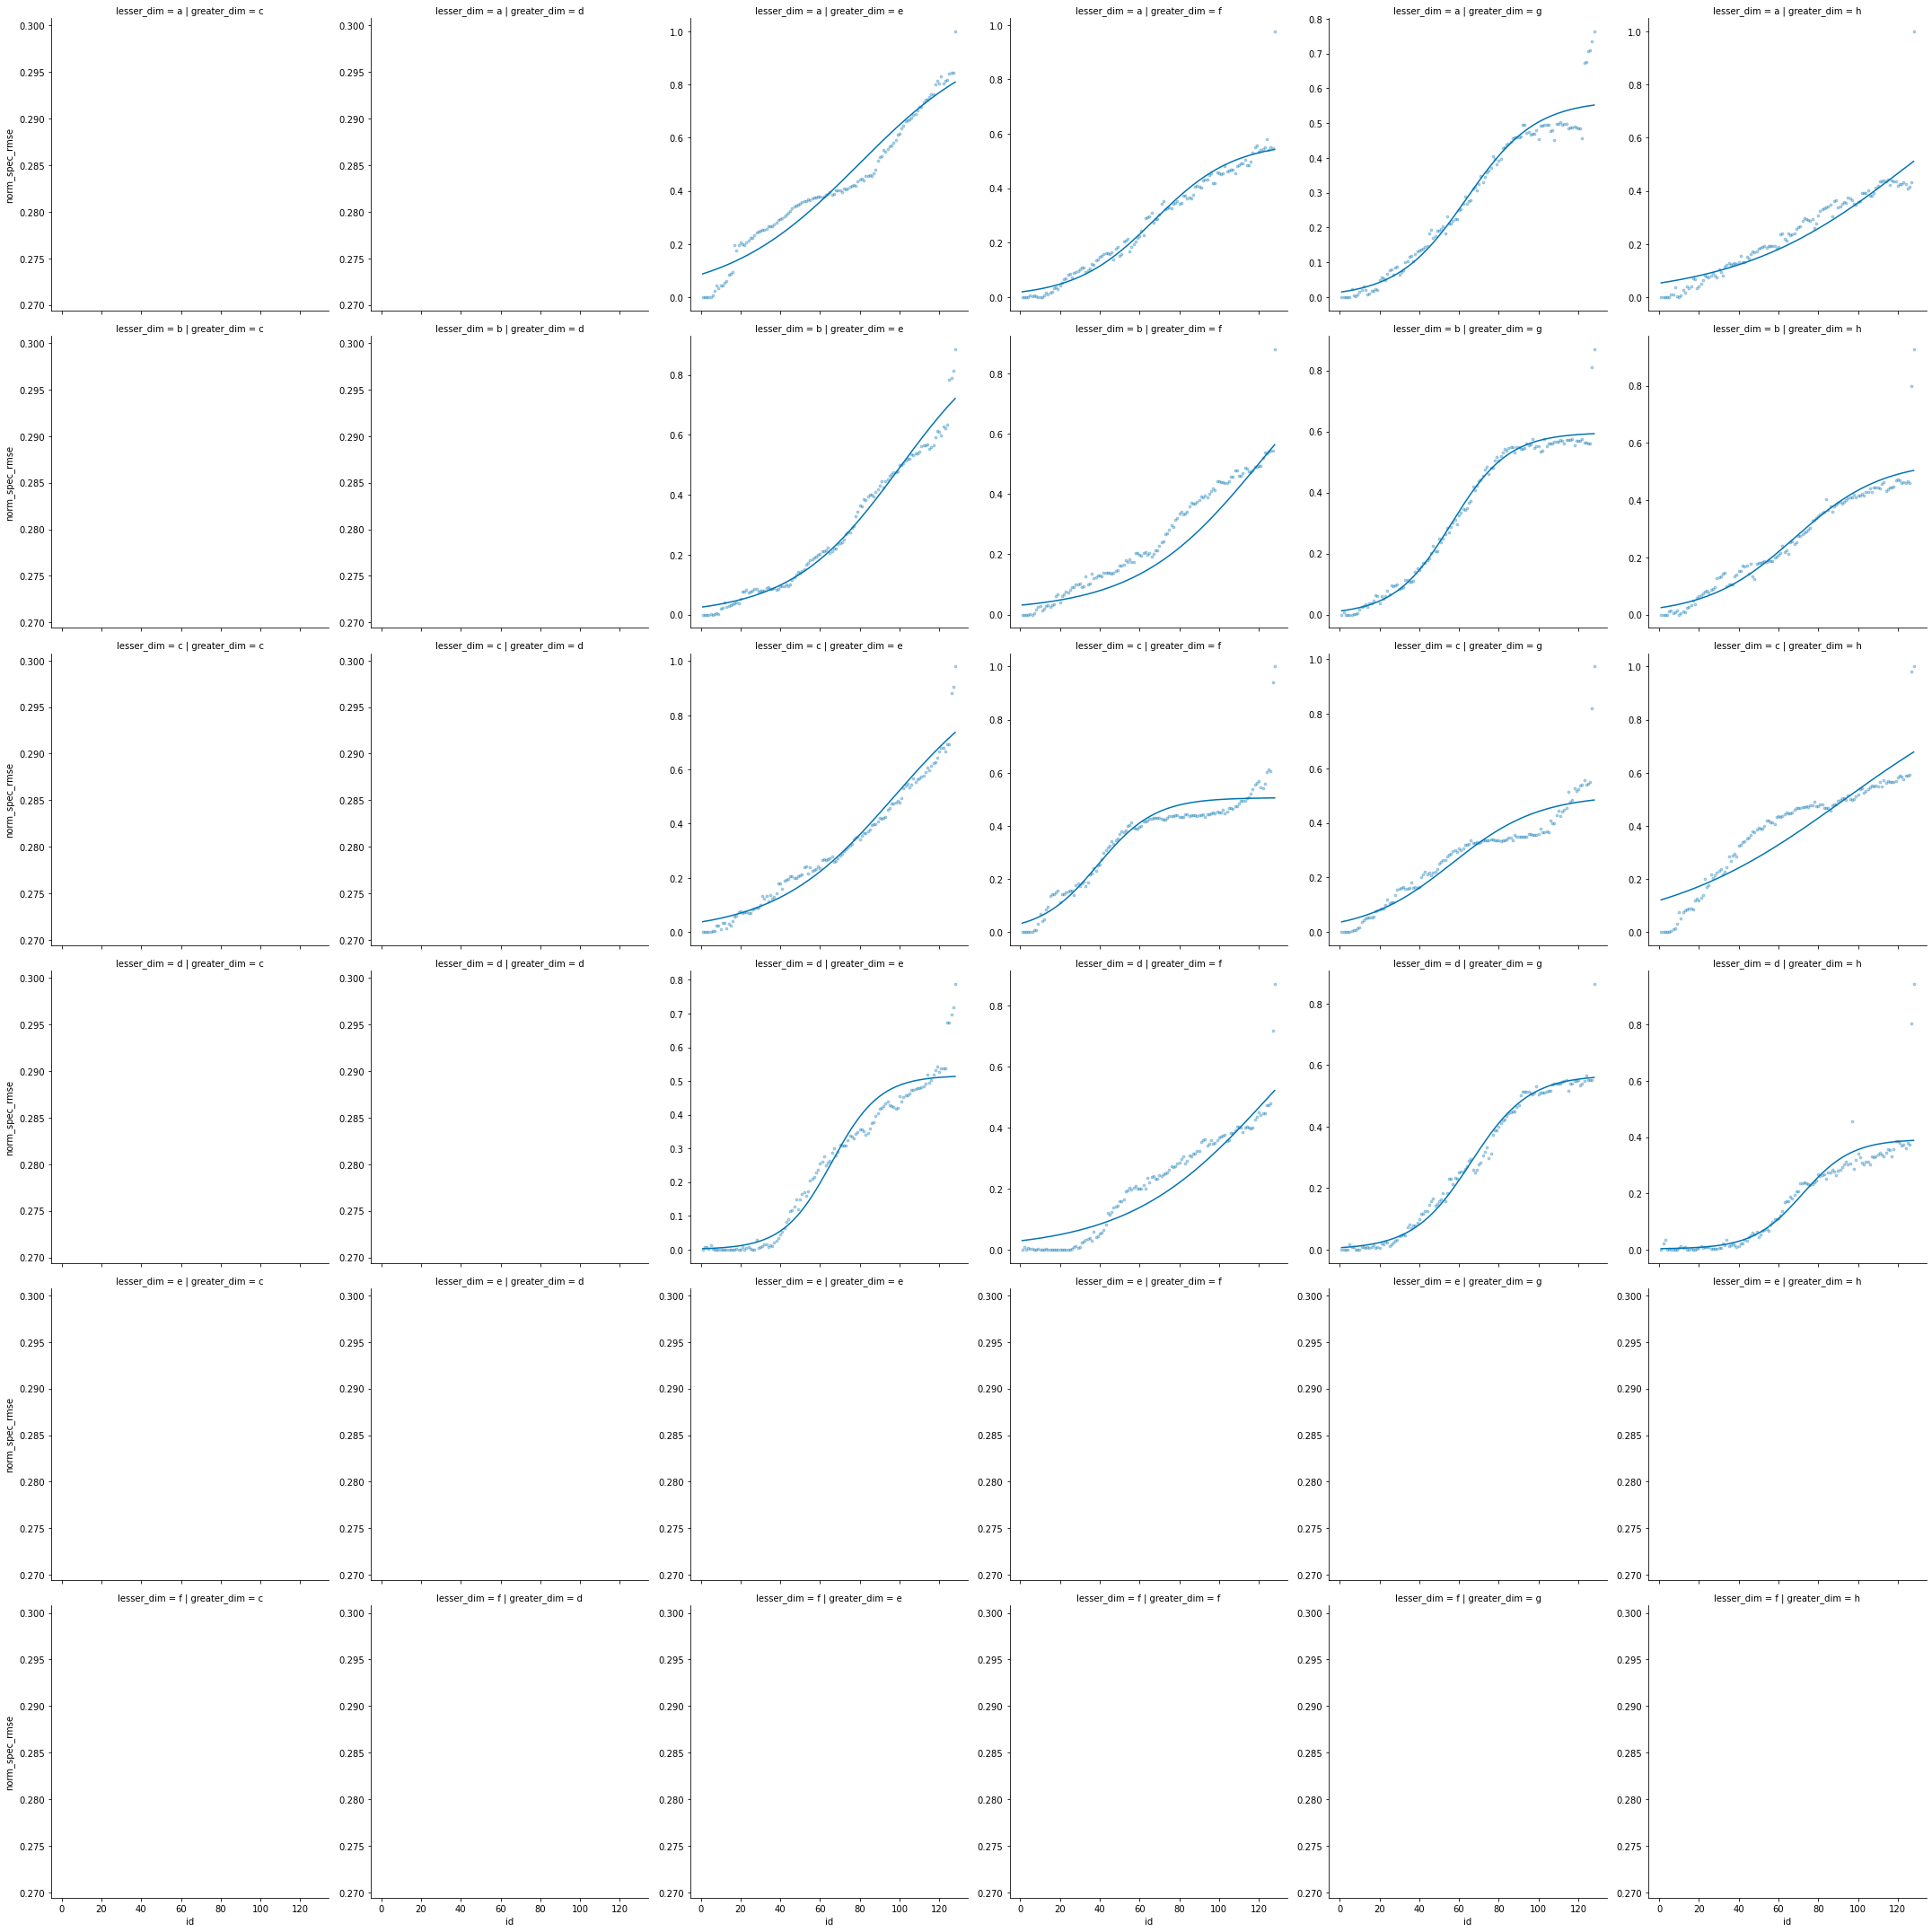

In [27]:
g = sns.lmplot(data=morph_df_1, 
           x='id', 
           y='norm_spec_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(fourpl, "id", "norm_spec_rmse")

/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2


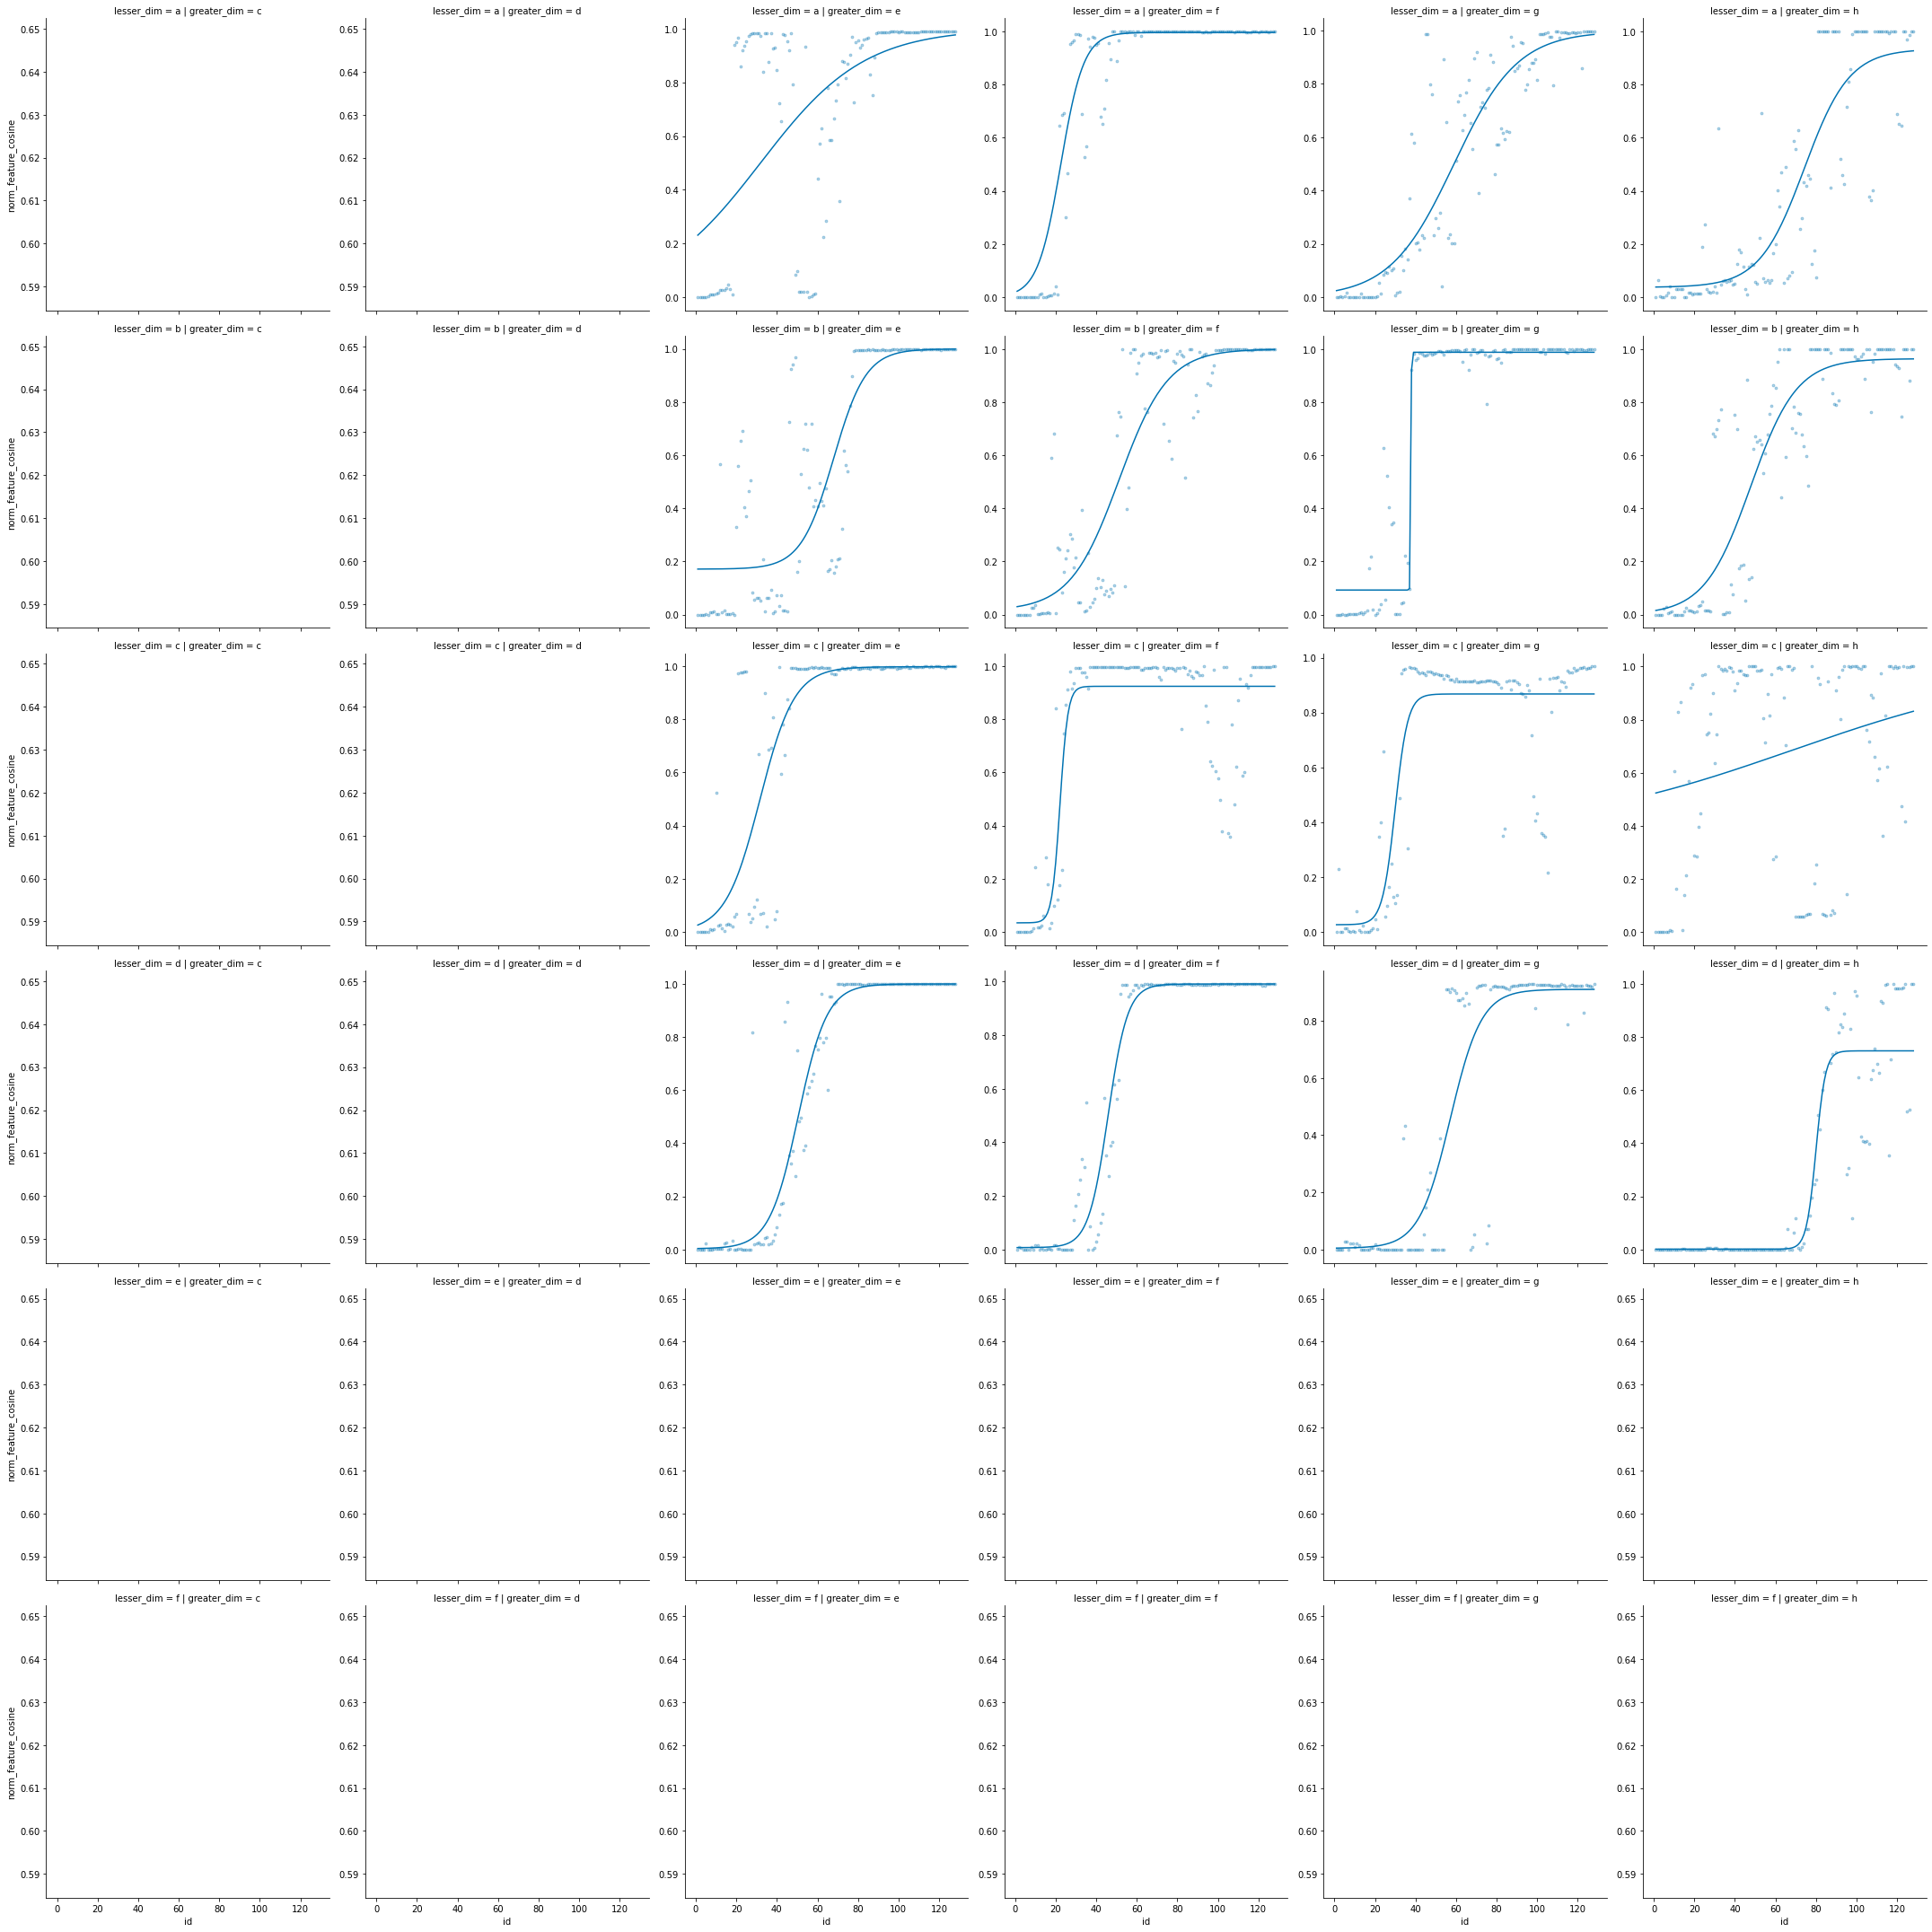

In [28]:
g = sns.lmplot(data=morph_df_1, 
           x='id', 
           y='norm_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(fourpl, "id", "norm_feature_cosine")

# Group 2

In [29]:
group_stim_cats = generate_stim_combos('abgh', 'cdef')

weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group2/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

cat_list = []
id_list = []
feature_rmse_list_init = []
feature_cosine_list_init = []
spec_rmse_list_init = []
feature_rmse_list_final = []
feature_cosine_list_final = []
spec_rmse_list_final = []
less_dim_list = []
more_dim_list = []

feature_rmse_list_comb = []
feature_cosine_list_comb = []
spec_rmse_list_comb = []

feature_rmse_list_norm = []
feature_cosine_list_norm = []
spec_rmse_list_norm = []


for cat in group_stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # cat lists
    feature_rmse_list_init_cat = []
    feature_cosine_list_init_cat = []
    spec_rmse_list_init_cat = []
    
    feature_rmse_list_final_cat = []
    feature_cosine_list_final_cat = []
    spec_rmse_list_final_cat = []
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
        feature_rmse_list_init_cat.append(init_feature_rmse)
        feature_rmse_list_final_cat.append(final_feature_rmse)
        feature_cosine_list_init_cat.append(init_feature_cosine)
        feature_cosine_list_final_cat.append(final_feature_cosine)
        spec_rmse_list_init_cat.append(init_spec_rmse)
        spec_rmse_list_final_cat.append(final_spec_rmse)
        
    feature_rmse_list_init += feature_rmse_list_init_cat
    feature_rmse_list_final += feature_rmse_list_final_cat
    feature_cosine_list_init += feature_cosine_list_init_cat
    feature_cosine_list_final += feature_cosine_list_final_cat
    spec_rmse_list_init += spec_rmse_list_init_cat
    spec_rmse_list_final += spec_rmse_list_final_cat
    
    feature_rmse_list_comb_cat = distance_ratio(feature_rmse_list_init_cat, feature_rmse_list_final_cat)
    feature_cosine_list_comb_cat = distance_ratio(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
    spec_rmse_list_comb_cat = distance_ratio(spec_rmse_list_init_cat, spec_rmse_list_final_cat)
    
    feature_rmse_list_comb += feature_rmse_list_comb_cat
    feature_cosine_list_comb += feature_cosine_list_comb_cat
    spec_rmse_list_comb += spec_rmse_list_comb_cat
    
    feature_rmse_list_norm += normalize_robust(feature_rmse_list_comb_cat)
    feature_cosine_list_norm += normalize_robust(feature_cosine_list_comb_cat)
    spec_rmse_list_norm += normalize_robust(spec_rmse_list_comb_cat)
    
    paragraph_print(f'Done with {cat}', separation='*')

morph_df_2 = pd.DataFrame()
morph_df_2['morph_dim'] = cat_list
morph_df_2['id'] = id_list

morph_df_2['lesser_dim'] = less_dim_list
morph_df_2['greater_dim'] = more_dim_list
morph_df_2['init_feature_rmse'] = feature_rmse_list_init
morph_df_2['final_feature_rmse'] = feature_rmse_list_final
morph_df_2['init_feature_cosine'] = feature_cosine_list_init
morph_df_2['final_feature_cosine'] = feature_cosine_list_final
morph_df_2['init_spec_rmse'] = spec_rmse_list_init
morph_df_2['final_spec_rmse'] = spec_rmse_list_final

morph_df_2['comb_feature_rmse'] = feature_rmse_list_comb
morph_df_2['comb_feature_cosine'] = feature_cosine_list_comb
morph_df_2['comb_spec_rmse'] = spec_rmse_list_comb

morph_df_2['norm_feature_rmse'] = feature_rmse_list_norm
morph_df_2['norm_feature_cosine'] = feature_cosine_list_norm
morph_df_2['norm_spec_rmse'] = spec_rmse_list_norm

morph_df_2.head()

Done with ac
**************************************************
Done with ad
**************************************************
Done with ae
**************************************************
Done with af
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with cg
**************************************************
Done with dg
**************************************************
Done with eg
**************************************************
Done with fg
**************************************************
Done with ch
**************************************************
Done with dh
**************************************************
Done with eh
**************************************************
Done with fh
***************************

,morph_dim,id,lesser_dim,greater_dim,init_feature_rmse,final_feature_rmse,init_feature_cosine,final_feature_cosine,init_spec_rmse,final_spec_rmse,comb_feature_rmse,comb_feature_cosine,comb_spec_rmse,norm_feature_rmse,norm_feature_cosine,norm_spec_rmse
0,ac,1,a,c,0.000000,0.529166,0.000000,0.573461,0.000000,0.287843,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,ac,2,a,c,0.008481,0.523122,0.000008,0.574694,0.031305,0.285881,0.015954,0.000014,0.098695,0.000000,0.000000,0.0
2,ac,3,a,c,0.020683,0.509569,0.000094,0.561916,0.041361,0.283337,0.039007,0.000168,0.127382,0.000000,0.000000,0.0
3,ac,4,a,c,0.019757,0.510339,0.000101,0.561626,0.045071,0.282070,0.037271,0.000180,0.137772,0.000000,0.000000,0.0
4,ac,5,a,c,0.039969,0.491101,0.000602,0.545875,0.049386,0.281522,0.075262,0.001102,0.149243,0.007026,0.000184,0.0


/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2


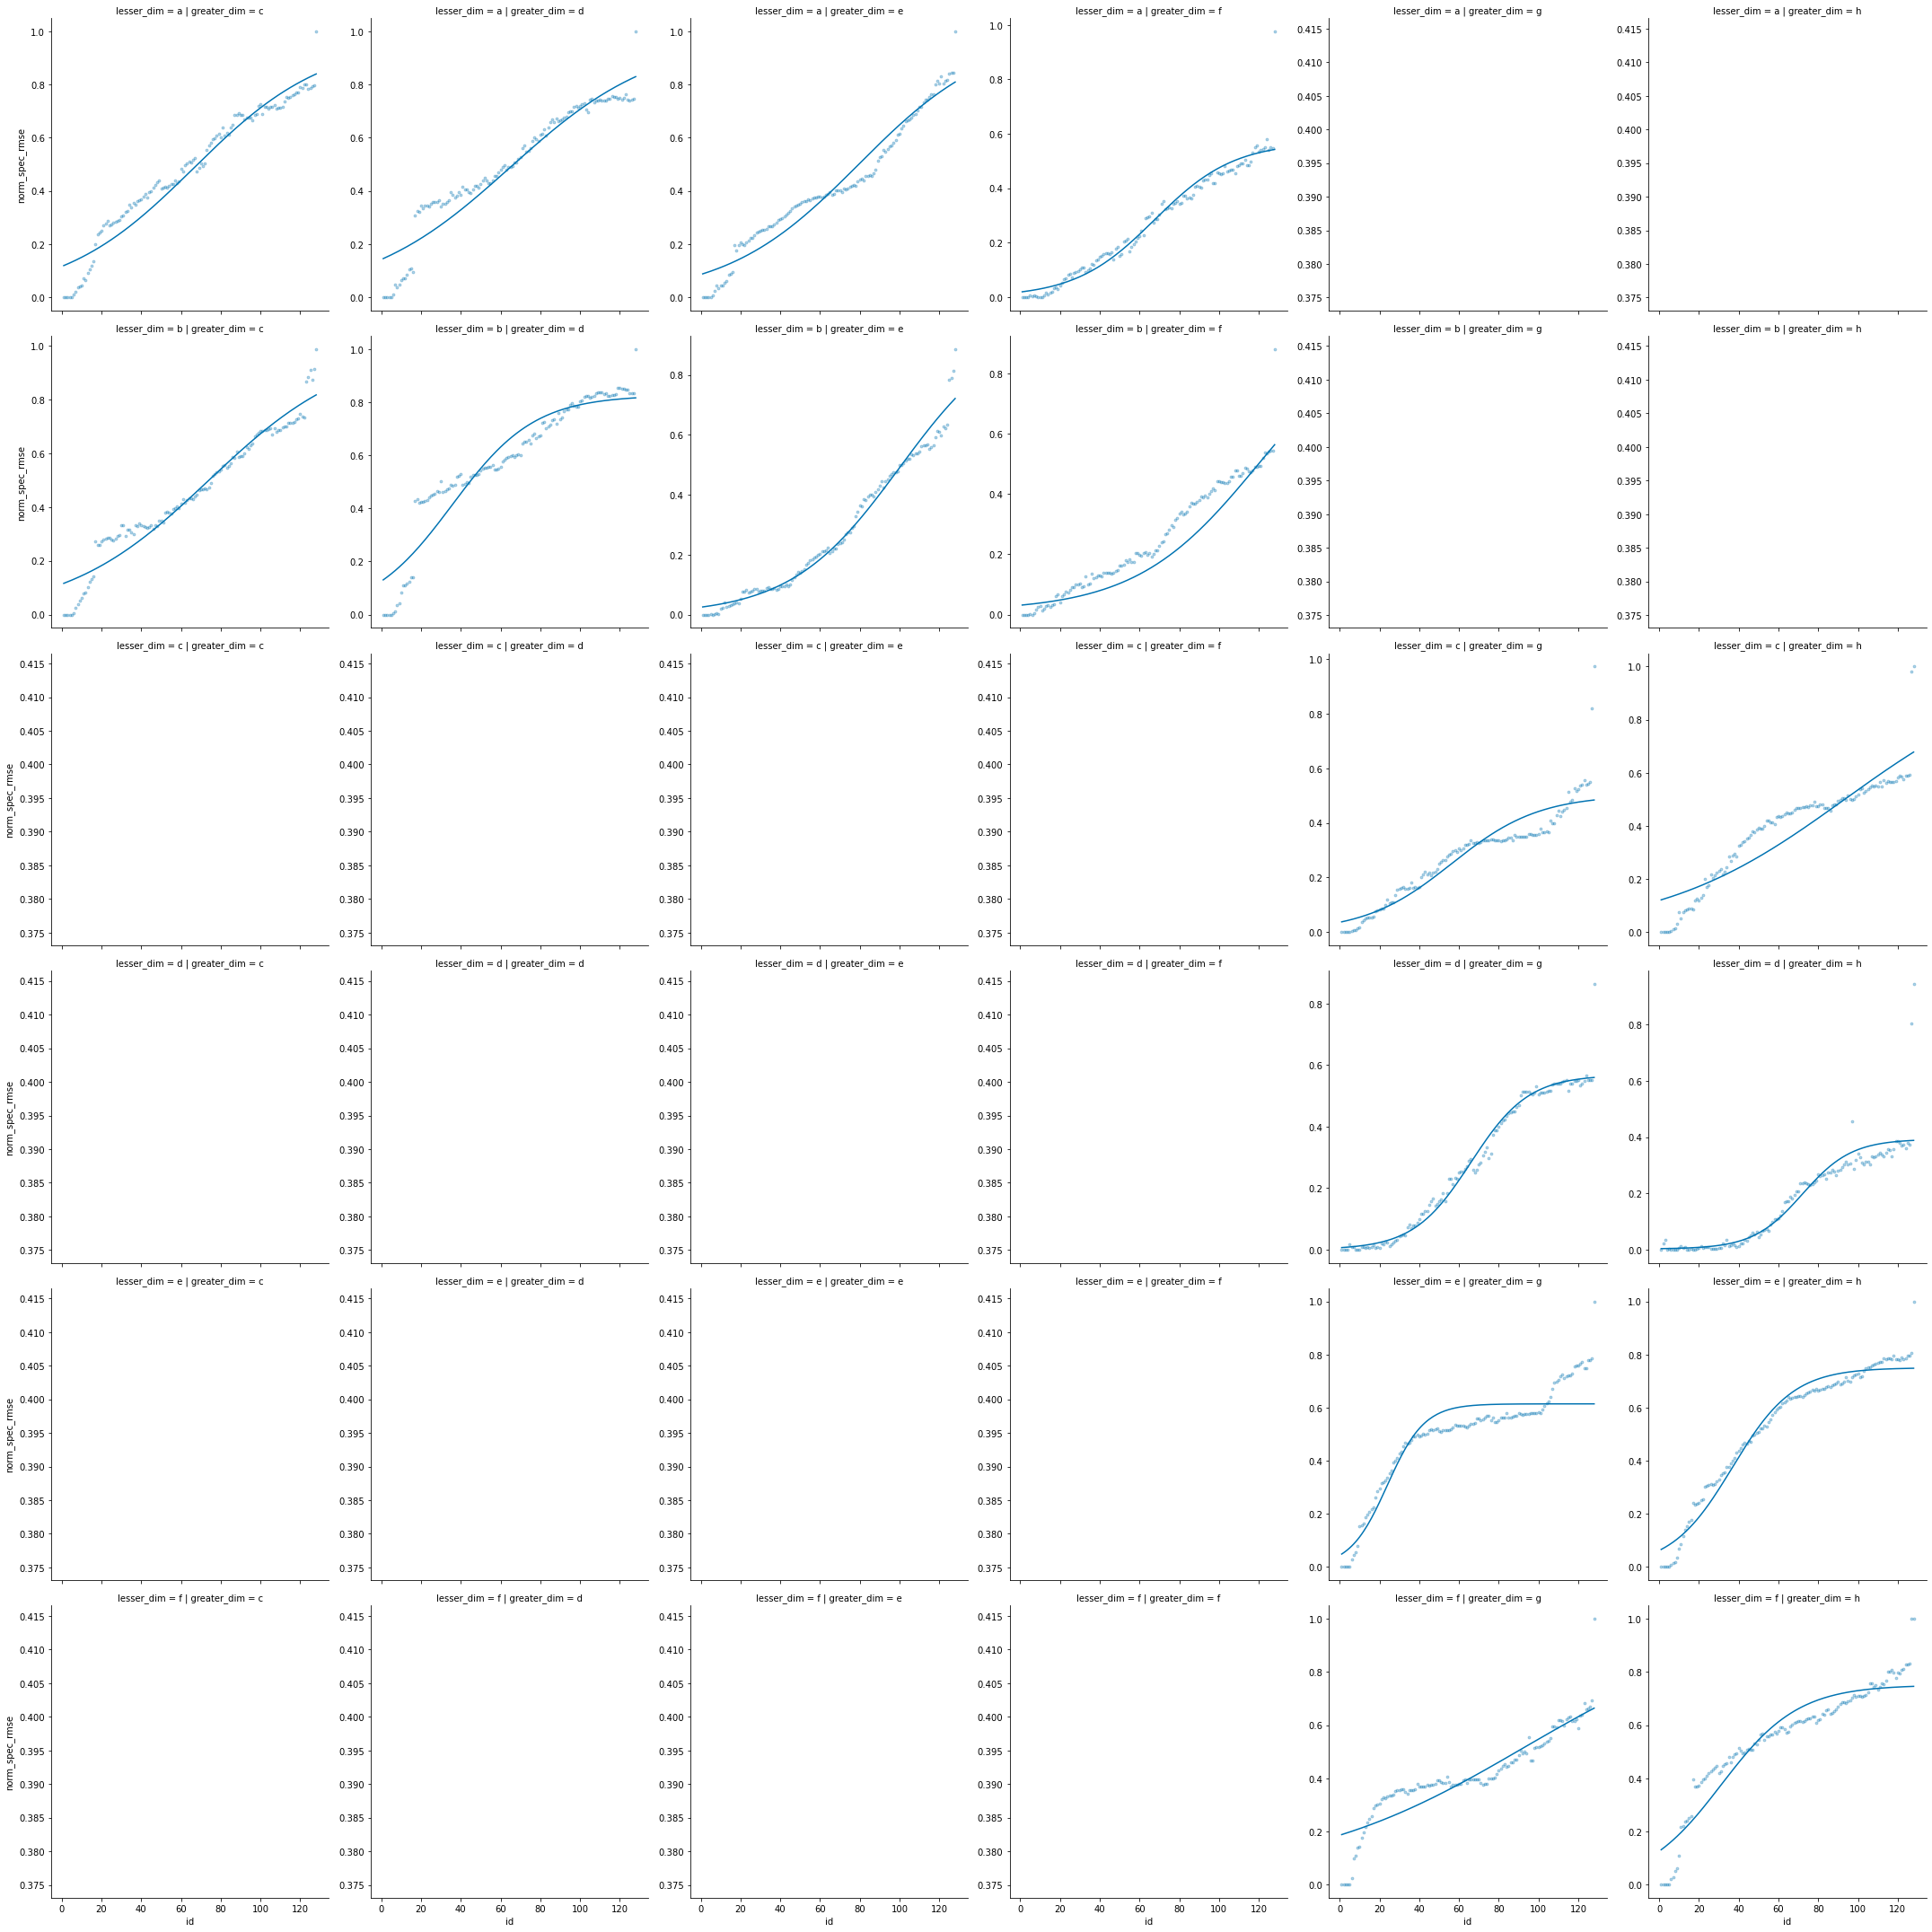

In [30]:
g = sns.lmplot(data=morph_df_2, 
           x='id', 
           y='norm_spec_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(fourpl, "id", "norm_spec_rmse")

/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) /

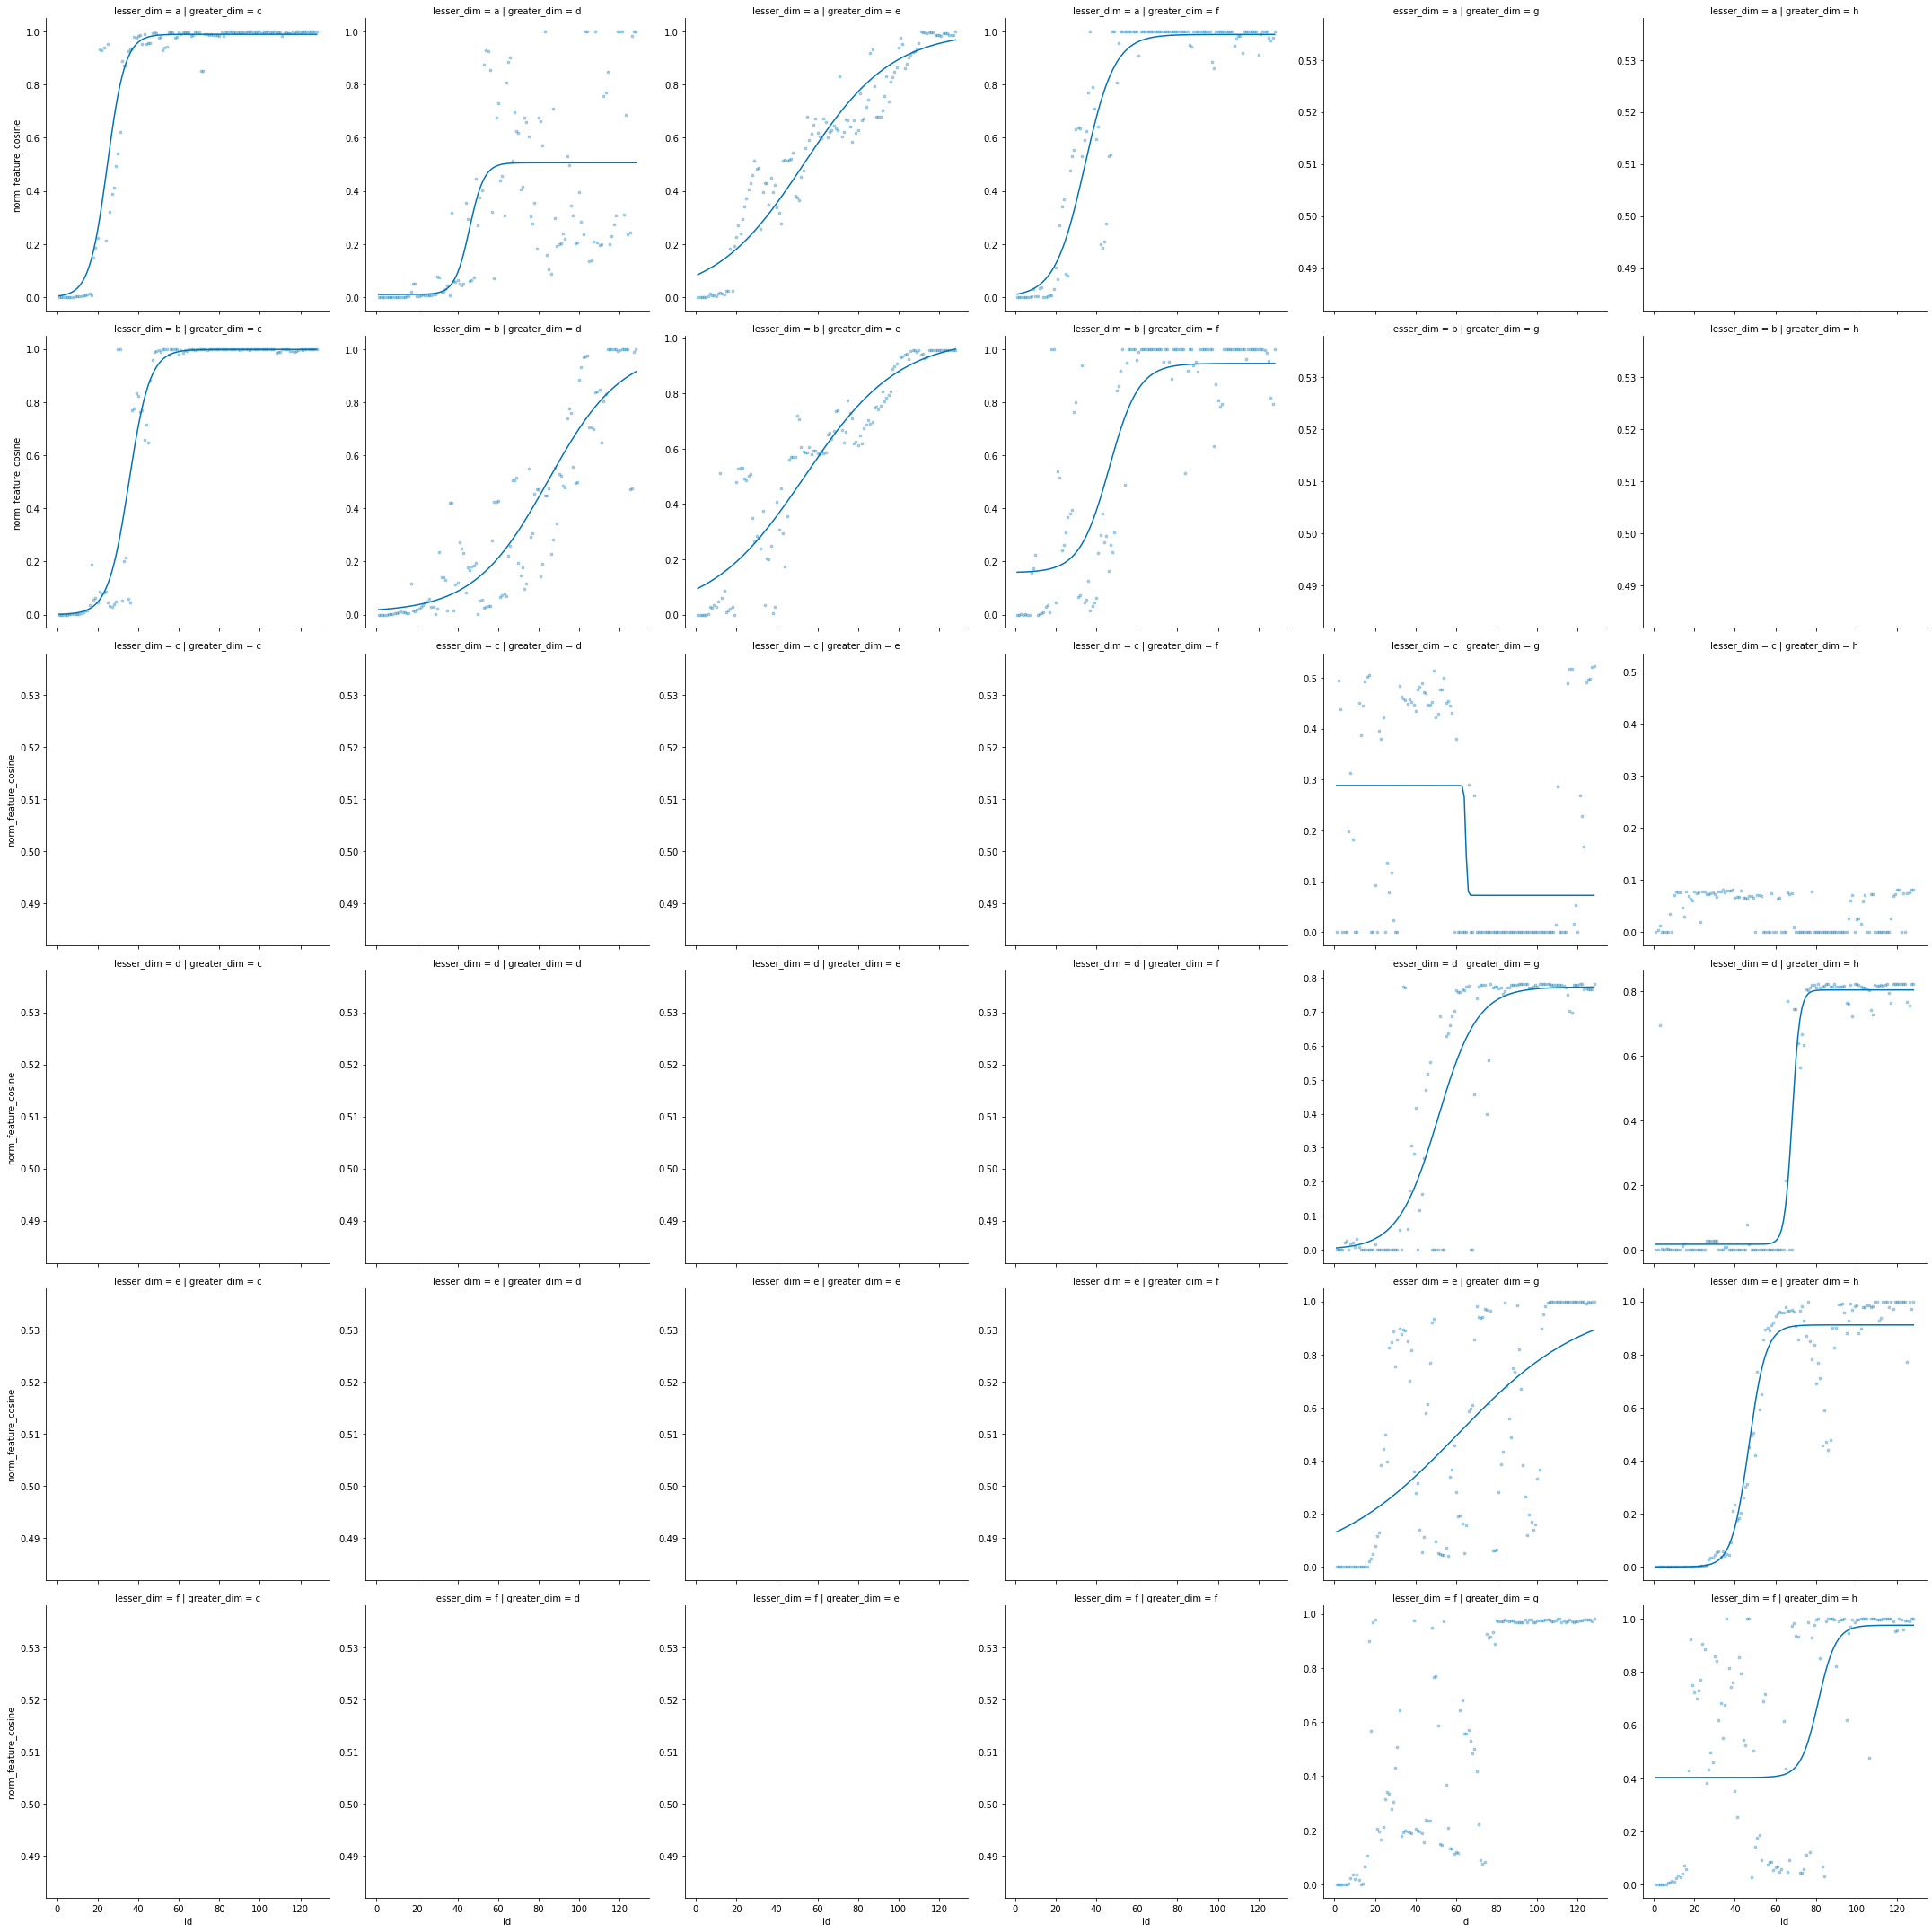

In [31]:
g = sns.lmplot(data=morph_df_2, 
           x='id', 
           y='norm_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(fourpl, "id", "norm_feature_cosine")

# Group 3

In [32]:
group_stim_cats = generate_stim_combos('abef', 'cdgh')

weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group3/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

cat_list = []
id_list = []
feature_rmse_list_init = []
feature_cosine_list_init = []
spec_rmse_list_init = []
feature_rmse_list_final = []
feature_cosine_list_final = []
spec_rmse_list_final = []
less_dim_list = []
more_dim_list = []

feature_rmse_list_comb = []
feature_cosine_list_comb = []
spec_rmse_list_comb = []

feature_rmse_list_norm = []
feature_cosine_list_norm = []
spec_rmse_list_norm = []


for cat in group_stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # cat lists
    feature_rmse_list_init_cat = []
    feature_cosine_list_init_cat = []
    spec_rmse_list_init_cat = []
    
    feature_rmse_list_final_cat = []
    feature_cosine_list_final_cat = []
    spec_rmse_list_final_cat = []
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
        feature_rmse_list_init_cat.append(init_feature_rmse)
        feature_rmse_list_final_cat.append(final_feature_rmse)
        feature_cosine_list_init_cat.append(init_feature_cosine)
        feature_cosine_list_final_cat.append(final_feature_cosine)
        spec_rmse_list_init_cat.append(init_spec_rmse)
        spec_rmse_list_final_cat.append(final_spec_rmse)
        
    feature_rmse_list_init += feature_rmse_list_init_cat
    feature_rmse_list_final += feature_rmse_list_final_cat
    feature_cosine_list_init += feature_cosine_list_init_cat
    feature_cosine_list_final += feature_cosine_list_final_cat
    spec_rmse_list_init += spec_rmse_list_init_cat
    spec_rmse_list_final += spec_rmse_list_final_cat
    
    feature_rmse_list_comb_cat = distance_ratio(feature_rmse_list_init_cat, feature_rmse_list_final_cat)
    feature_cosine_list_comb_cat = distance_ratio(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
    spec_rmse_list_comb_cat = distance_ratio(spec_rmse_list_init_cat, spec_rmse_list_final_cat)
    
    feature_rmse_list_comb += feature_rmse_list_comb_cat
    feature_cosine_list_comb += feature_cosine_list_comb_cat
    spec_rmse_list_comb += spec_rmse_list_comb_cat
    
    feature_rmse_list_norm += normalize_robust(feature_rmse_list_comb_cat)
    feature_cosine_list_norm += normalize_robust(feature_cosine_list_comb_cat)
    spec_rmse_list_norm += normalize_robust(spec_rmse_list_comb_cat)
    
    paragraph_print(f'Done with {cat}', separation='*')

morph_df_3 = pd.DataFrame()
morph_df_3['morph_dim'] = cat_list
morph_df_3['id'] = id_list

morph_df_3['lesser_dim'] = less_dim_list
morph_df_3['greater_dim'] = more_dim_list
morph_df_3['init_feature_rmse'] = feature_rmse_list_init
morph_df_3['final_feature_rmse'] = feature_rmse_list_final
morph_df_3['init_feature_cosine'] = feature_cosine_list_init
morph_df_3['final_feature_cosine'] = feature_cosine_list_final
morph_df_3['init_spec_rmse'] = spec_rmse_list_init
morph_df_3['final_spec_rmse'] = spec_rmse_list_final

morph_df_3['comb_feature_rmse'] = feature_rmse_list_comb
morph_df_3['comb_feature_cosine'] = feature_cosine_list_comb
morph_df_3['comb_spec_rmse'] = spec_rmse_list_comb

morph_df_3['norm_feature_rmse'] = feature_rmse_list_norm
morph_df_3['norm_feature_cosine'] = feature_cosine_list_norm
morph_df_3['norm_spec_rmse'] = spec_rmse_list_norm

morph_df_3.head()

Done with ac
**************************************************
Done with ad
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with de
**************************************************
Done with eg
**************************************************
Done with eh
**************************************************
Done with cf
**************************************************
Done with df
**************************************************
Done with fg
**************************************************
Done with fh
***************************

,morph_dim,id,lesser_dim,greater_dim,init_feature_rmse,final_feature_rmse,init_feature_cosine,final_feature_cosine,init_spec_rmse,final_spec_rmse,comb_feature_rmse,comb_feature_cosine,comb_spec_rmse,norm_feature_rmse,norm_feature_cosine,norm_spec_rmse
0,ac,1,a,c,0.000000,0.481859,0.000000,0.456266,0.000000,0.287843,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,ac,2,a,c,0.010513,0.472168,0.000017,0.452003,0.031305,0.285881,0.021781,0.000037,0.098695,0.000000,0.000000,0.0
2,ac,3,a,c,0.025492,0.457428,0.000271,0.438983,0.041361,0.283337,0.052787,0.000617,0.127382,0.000000,0.000000,0.0
3,ac,4,a,c,0.023762,0.459261,0.000284,0.439136,0.045071,0.282070,0.049195,0.000645,0.137772,0.000000,0.000000,0.0
4,ac,5,a,c,0.037872,0.445711,0.000709,0.428878,0.049386,0.281522,0.078315,0.001650,0.149243,0.004961,0.000205,0.0


/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2


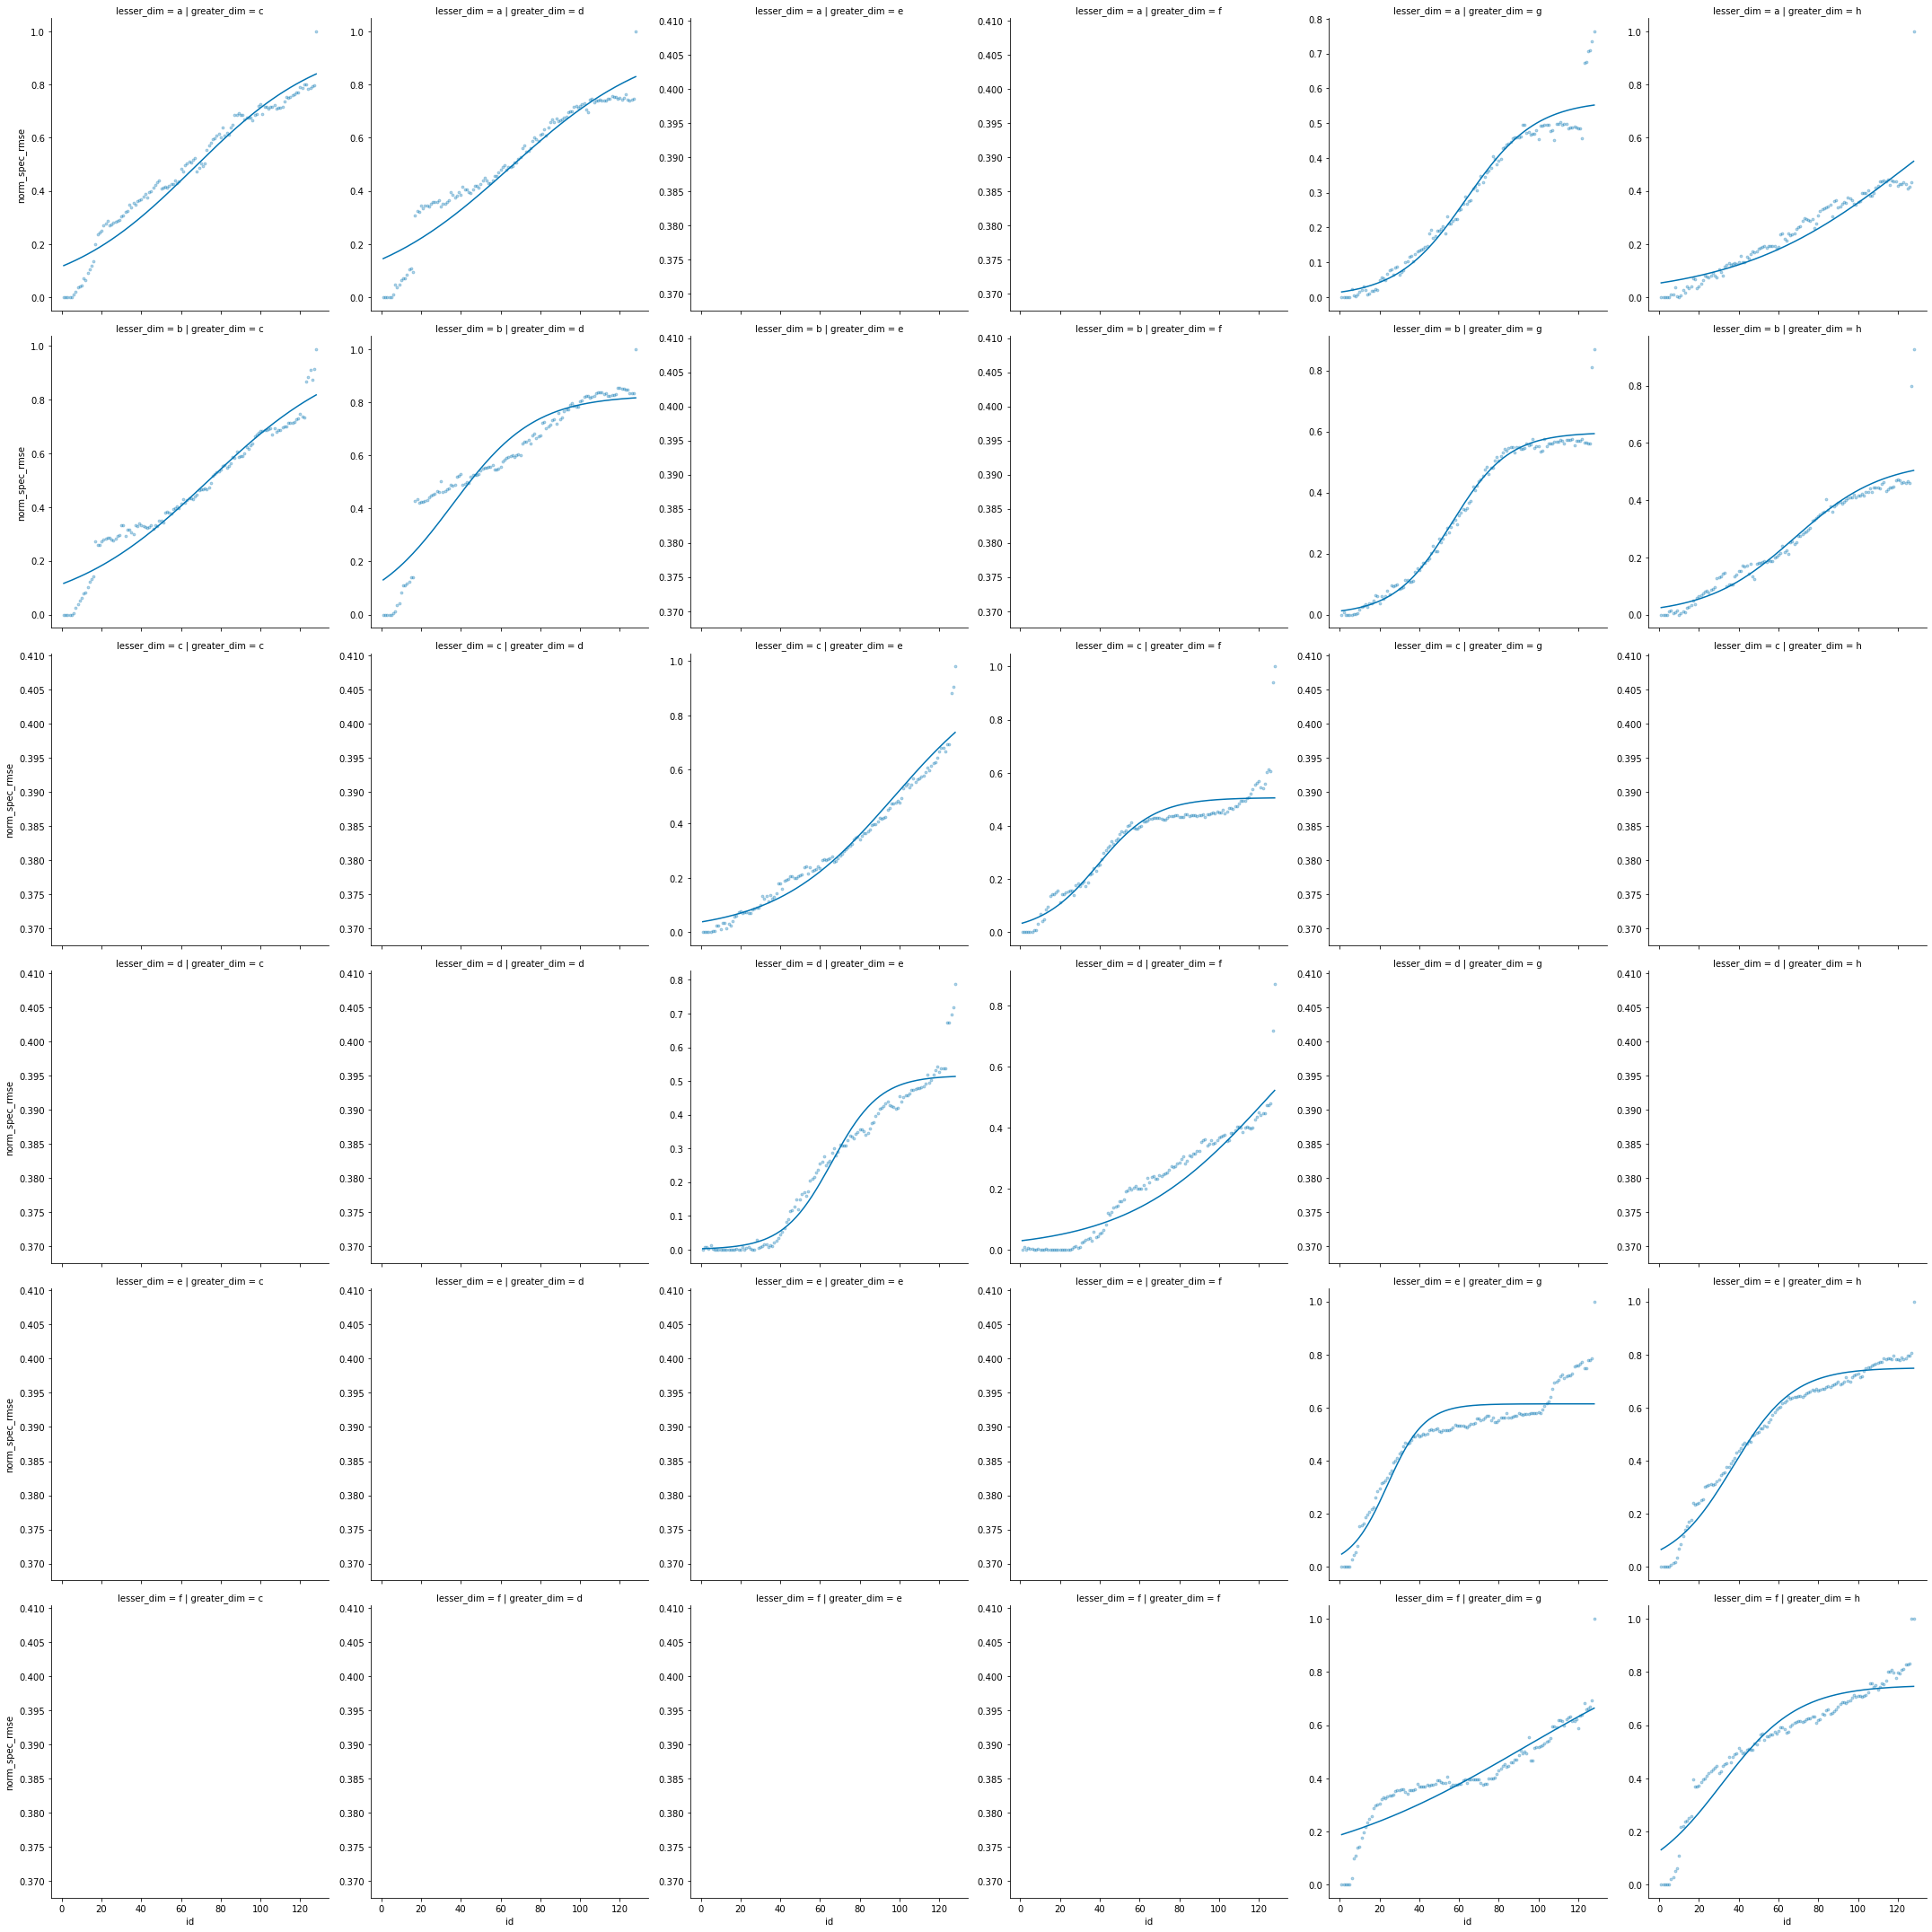

In [33]:
g = sns.lmplot(data=morph_df_3, 
           x='id', 
           y='norm_spec_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(fourpl, "id", "norm_spec_rmse")

# combine into df

In [34]:
def generate_group_stims(group):
    group_dic = {'1': ('abcd', 'efgh'), '2': ('abgh', 'cdef'), '3':('abef', 'cdgh')}
    return generate_stim_combos(group_dic[group][0], group_dic[group][1])

## 4pl

In [35]:
all_df = pd.DataFrame()

for group in ['1', '2', '3']:    
    group_fcosine = {}
    group_frmse = {}
    group_rmse = {}
    
    morph_df_group = eval('morph_df_'+group)
    group_stim_cats = generate_group_stims(group)
    
    for i, morph_dim in enumerate(group_stim_cats):
        
        reduced_morph_df = morph_df_group[morph_df_group.morph_dim==morph_dim].reset_index(drop=True)
        ids = np.array(reduced_morph_df.id.values.tolist())
        fcosine_l = np.array(reduced_morph_df.norm_feature_cosine.values.tolist())
        frmse_l = np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
        rmse_l = np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
        fcosine_p = fit_4pl(ids, fcosine_l)
        frmse_p = fit_4pl(ids, frmse_l)
        rmse_p = fit_4pl(ids, rmse_l)

        if isinstance(fcosine_p, bool) or isinstance(frmse_p, bool) or isinstance(rmse_p, bool):
            continue
        else:
            group_fcosine[morph_dim] = fcosine_p
            group_frmse[morph_dim] = frmse_p
            group_rmse[morph_dim] = rmse_p
    group_df_rmse = pd.DataFrame.from_dict(group_rmse, 
                                                orient='index', 
                                                columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
    group_df_frmse = pd.DataFrame.from_dict(group_frmse, 
                                                orient='index', 
                                                columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
    group_df_fcosine = pd.DataFrame.from_dict(group_fcosine, 
                                                orient='index', 
                                                columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

    group_df_rmse['group'] = 'Group '+group
    group_df_frmse['group'] = 'Group '+group
    group_df_fcosine['group'] = 'Group '+group

    group_df_rmse['metric'] = 'rmse'
    group_df_frmse['metric'] = 'frmse'
    group_df_fcosine['metric'] = 'fcosine'

    group_df = pd.concat([group_df_rmse, group_df_frmse, group_df_fcosine]).reset_index(drop=True)
    all_df = pd.concat([all_df, group_df]).reset_index(drop=True)

/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid 

In [36]:
all_df

,index,min_val,max_val,slope,inflection,group,metric
0,ae,1.000000e-16,1.000000,0.029875,79.470487,Group 1,rmse
1,af,1.000000e-16,0.568973,0.050084,67.639823,Group 1,rmse
2,ag,1.000000e-16,0.565611,0.057494,63.763143,Group 1,rmse
3,ah,1.000000e-16,1.000000,0.022960,125.997597,Group 1,rmse
4,be,1.000000e-16,0.980336,0.036597,100.000082,Group 1,rmse
...,...,...,...,...,...,...,...
130,eh,3.371431e-04,0.756523,0.569969,21.657001,Group 3,fcosine
131,cf,1.000000e-16,0.899866,0.033713,67.386564,Group 3,fcosine
132,df,1.131193e-01,0.855051,0.466960,48.399446,Group 3,fcosine
133,fg,2.528452e-01,0.902028,3.431029,79.451172,Group 3,fcosine


In [38]:
results_folder=extend_folder(results_folder, 'norm_robust')

In [39]:
all_df.to_pickle(os.path.join(results_folder, 'all_predicted.p'))

# Ignore the rest

## 2pl

In [40]:
all_df = pd.DataFrame()

for group in ['1', '2', '3']:    
    group_fcosine = {}
    group_frmse = {}
    group_rmse = {}
    
    morph_df_group = eval('morph_df_'+group)
    group_stim_cats = generate_group_stims(group)
    
    for i, morph_dim in enumerate(group_stim_cats):
        
        reduced_morph_df = morph_df_group[morph_df_group.morph_dim==morph_dim].reset_index(drop=True)
        ids = np.array(reduced_morph_df.id.values.tolist())
        fcosine_l = np.array(reduced_morph_df.norm_feature_cosine.values.tolist())
        frmse_l = np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
        rmse_l = np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
        fcosine_p = fit_2pl(ids, fcosine_l)
        frmse_p = fit_2pl(ids, frmse_l)
        rmse_p = fit_4pl(ids, rmse_l)

        if isinstance(fcosine_p, bool) or isinstance(frmse_p, bool) or isinstance(rmse_p, bool):
            continue
        else:
            group_fcosine[morph_dim] = fcosine_p
            group_frmse[morph_dim] = frmse_p
            group_rmse[morph_dim] = rmse_p[2:]
    group_df_rmse = pd.DataFrame.from_dict(group_rmse, 
                                                orient='index', 
                                                columns=['slope', 'inflection']).reset_index()
    group_df_frmse = pd.DataFrame.from_dict(group_frmse, 
                                                orient='index', 
                                                columns=['slope', 'inflection']).reset_index()
    group_df_fcosine = pd.DataFrame.from_dict(group_fcosine, 
                                                orient='index', 
                                                columns=['slope', 'inflection']).reset_index()

    group_df_rmse['group'] = 'Group '+group
    group_df_frmse['group'] = 'Group '+group
    group_df_fcosine['group'] = 'Group '+group

    group_df_rmse['metric'] = 'rmse'
    group_df_frmse['metric'] = 'frmse'
    group_df_fcosine['metric'] = 'fcosine'

    group_df = pd.concat([group_df_rmse, group_df_frmse, group_df_fcosine]).reset_index(drop=True)
    all_df = pd.concat([all_df, group_df]).reset_index(drop=True)

/mnt/cube/kai/repositories/star_scale/math_utils.py:636: RuntimeWarning: divide by zero encountered in log
  return np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
/mnt/cube/kai/repositories/star_scale/math_utils.py:667: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(y * d_p_2pl / (p_2pl) - (1 - y) * d_p_2pl / (1 - p_2pl), 1)
/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: Runti

In [41]:
all_df.to_pickle(os.path.join(results_folder, 'all_predicted_2pl.p'))

In [47]:
morph_df_1

,morph_dim,id,lesser_dim,greater_dim,init_feature_rmse,final_feature_rmse,init_feature_cosine,final_feature_cosine,init_spec_rmse,final_spec_rmse,comb_feature_rmse,comb_feature_cosine,comb_spec_rmse,norm_feature_rmse,norm_feature_cosine,norm_spec_rmse
0,ae,1,a,e,0.000000,0.551171,0.000000,0.706243,0.000000,0.278840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ae,2,a,e,0.028815,0.527265,0.000432,0.689333,0.010870,0.278188,0.051818,0.000626,0.037604,0.000000,0.000000,0.000000
2,ae,3,a,e,0.049293,0.511064,0.001214,0.679294,0.016957,0.277632,0.087967,0.001784,0.057560,0.000000,0.000000,0.000000
3,ae,4,a,e,0.074563,0.490645,0.003307,0.660766,0.021380,0.278018,0.131921,0.004979,0.071410,0.000000,0.000000,0.000000
4,ae,5,a,e,0.090975,0.477298,0.005139,0.648345,0.024051,0.277325,0.160091,0.007864,0.079804,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,dh,124,d,h,2.296155,0.164314,0.185518,0.013470,0.174112,0.065893,0.933219,0.932305,0.725452,0.920109,1.000000,0.628568
2044,dh,125,d,h,1.860688,0.275514,0.031324,0.022048,0.149705,0.062070,0.871026,0.586897,0.706906,0.851311,0.683521,0.602631
2045,dh,126,d,h,1.865773,0.270550,0.031692,0.021764,0.150894,0.061980,0.873357,0.592864,0.708843,0.853889,0.690473,0.605340
2046,dh,127,d,h,2.126400,0.008217,0.100567,0.000026,0.160355,0.008578,0.996151,0.999743,0.949223,0.989725,1.000000,0.941511


In [42]:
morph_df_1.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group1', 
                                             'morph_norm_robust.p'))
morph_df_2.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group2', 
                                             'morph_norm_robust.p'))
morph_df_3.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group3', 
                                             'morph_norm_robust.p'))